# Heterokaryon Peaks Comparison

Comparing peaks in early stages of sendai reprogramming with heterokaryon reprogramming. Using binary peak (present/not present) instead of counts.

In [1]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(parallel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max

In [186]:
cts <- read.csv("./data/scATAC.het.binary.peak.idr.500bp.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
cts = ifelse(cts>0, 1, 0)
head(cts, 2)
dim(cts)

,D0,D2,iPSC,batch1.nodox.MRC5,batch1.nodox.CC,batch1.nodox.3hr,batch1.nodox.16hr,batch2.dn.MRC5,batch2.dn.CC,batch2.dn.3hr,batch2.dn.16hr
chr1 196299 196803,1,1,0,0,0,0,0,0,0,0,0
chr1 502420 502920,0,0,0,0,0,0,0,1,0,0,0


[1] 204556     11

In [187]:
# remove batch2 for now
cts = cts[,!grepl("batch2", colnames(cts))]
cts = cts[rowSums(cts)>0, ]
dim(cts)

[1] 202612      7

In [188]:
library(RColorBrewer)

In [189]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [190]:
pca = prcomp(t(cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = colnames(cts)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

[1] 40.58 18.44 16.30 10.42  7.73  6.53  0.00


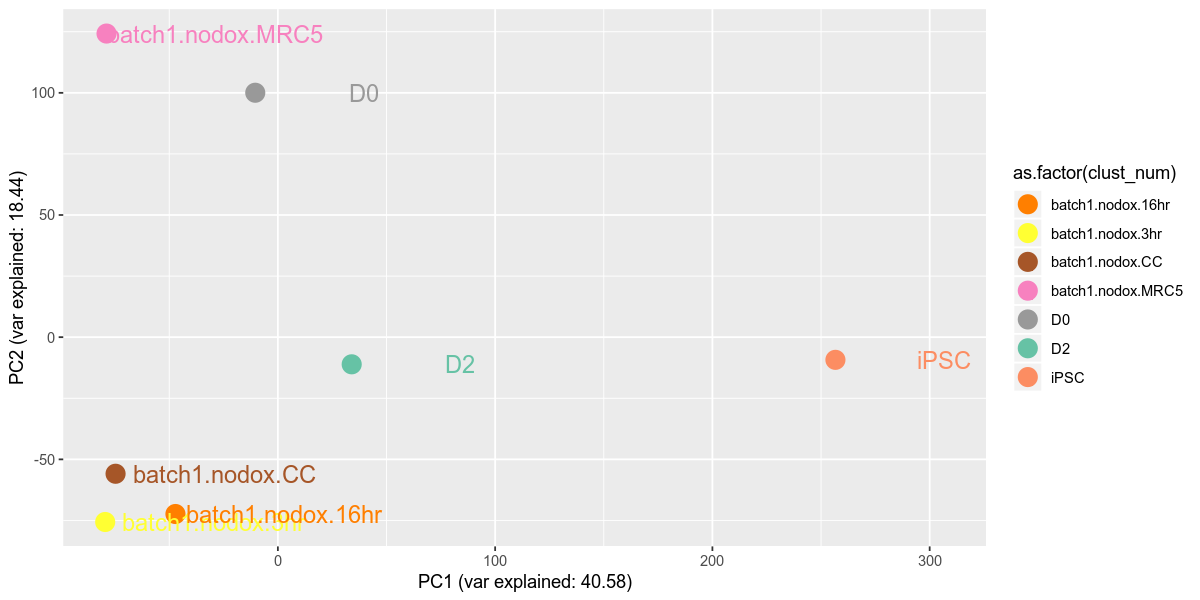

In [191]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
scale_colour_manual(values = col_vector[seq(50,67)]) +
geom_text(size=5, nudge_x=50)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

In [192]:
colSums(cts)

D0                D2              iPSC batch1.nodox.MRC5 
            88117             64787            103033            103321 
  batch1.nodox.CC  batch1.nodox.3hr batch1.nodox.16hr 
            61108             64136             58628

## Clustering

In [193]:
library(ClusterR)
library(viridis)
library(scales)

In [210]:
cts_to_cluster = cts[, c("D0", "batch1.nodox.3hr", "D2", "batch1.nodox.16hr", "iPSC")]
SAMPLES_TO_CLUSTER = c("D0", "batch1.nodox.3hr", "D2", "batch1.nodox.16hr")
# take only those that have at least one peak
cts_to_cluster = cts_to_cluster[rowSums(cts_to_cluster[, SAMPLES_TO_CLUSTER])>0, ]

In [211]:
compute_decimal <- function(x) {
    val = x[,1]
    for (i in seq(2,ncol(x))) {
        val = 2*val + x[,i]
    }
    
    val
}

In [212]:
# reorder based on hierarchical clustering
pr_mb = compute_decimal(cts_to_cluster[, SAMPLES_TO_CLUSTER])

In [213]:
# no hierarchical clustering, follow order of km_mb$centroids
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [214]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
 5113 12463   597  9194  6647   916  1268 21345  1890 12692  6079  5275 10064 
   14    15 
 3802 26970 

In [215]:
# DISPLAY_ORDER = c("D0", "batch2.dn.MRC5", "batch2.dn.CC", "batch2.dn.3hr", "D2", "batch2.dn.16hr", "iPSC")
# DISPLAY_ORDER = c("D0", "batch2.dn.MRC5", "D2", "batch2.dn.16hr", "iPSC")
cts_clustered = cts_to_cluster[order(pr_mb), ]
head(cts_clustered, 2)

,D0,batch1.nodox.3hr,D2,batch1.nodox.16hr,iPSC
chr1 3610505 3612362,0,0,0,1,1
chr1 3613339 3614110,0,0,0,1,1


In [219]:
mean(cts_to_cluster[which(pr_mb==1), "iPSC"])

[1] 0.2476041

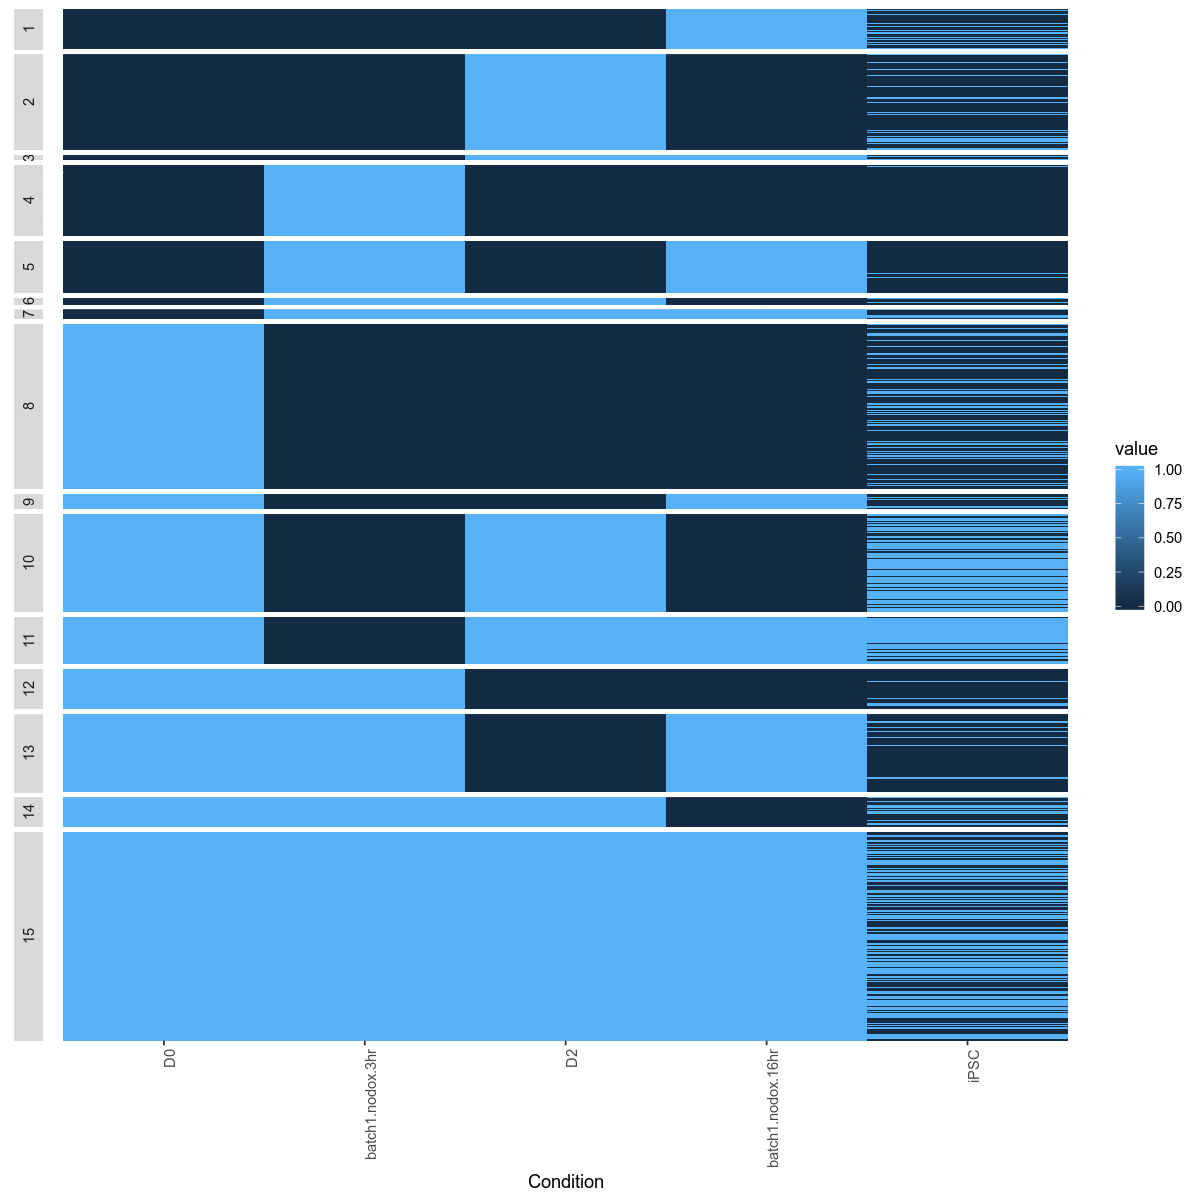

In [217]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 100) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(0, 1), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.1, "cm"))
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_tmp_heatmap_batch2_dn_D0_MRC5_D2_16hr_sorted_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

## Writing BED files for some clusters

In [204]:
CLUSTER_IDX = 1
NORM = 'binary_idr_500bp_D0_CC_D2_16hr'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200314_binary_idr_500bp_D0_CC_D2_16hr_n15/idx1.bed"

In [206]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(cts_to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [207]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_to_cluster), fileConn)
close(fileConn)

[1] "beds/20200314_binary_idr_500bp_D0_CC_D2_16hr_n15/all_peaks.bed"
